v11.10.16 - PySamplingQuality.py Tutorial and short description

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy

from IPython.display import Image

import os,sys
import subprocess as SB
os.chdir('Tutorial/')

sys.path.append('../')

# I. Preface

This notebook contains a short description and two examples how to use the 

>PySamplingQuality.py

tool to investigate the sampling quality of molecular dynamics (MD) simulations using a multi-trajectory approach. Details are explained in:

    Manuscript: Quantitative assessment of molecular dynamics sampling for flexible systems
    Authors: Mike Nemec and Daniel Hoffmann
    submitted to JCTC Aug.2016
    
Here, we will use

1. a command line representation generating configuration files
1. an IPython representation

calculating the overlap of two 100ns trajectories simulated with

1. Amber14
1. gromacs v4.6.5

This Tutorial is focused on the general options to run the quality assessment on conventional MD trajectories using mostly the default options. 

## Ia) Program versions

The tool was generated and tested using:

    Python     2.7.12
    Anaconda   2.4.1 (64-bit)
    Matplotlib 1.5.1
    scipy      0.17.0
    numpy      1.10.4
    
__Notes:__

- Matplotlib 1.2.0 or higher is required to use the plotting tools

# II. Required pre-processing

## 1. Trajectories

The only required files are the __post-processed trajectories__, possibly the __topology__ of the protein(s), possible __reference structures__ and __PySamplingQuality.py__.

Post-processed trajectories mean, that the protein is whole, without jumps and possibly re-covered periodic boundary conditions (PBC). Additionally, for simplicity, the water molecules and ions are deleted, because they are not part of the overlap analysis, and only every 0.1nm of the trajectories is used to make the files small.

Here, two trajectories of Met-Enkephalin (penta-peptide) simulated with Amber14

    Met_Amber1_stripped.pdb
    Met_Amber1_stripped.netcdf
    Met_Amber2_stripped.pdb
    Met_Amber2_stripped.netcdf
    Met_Amber_stripped.top
    

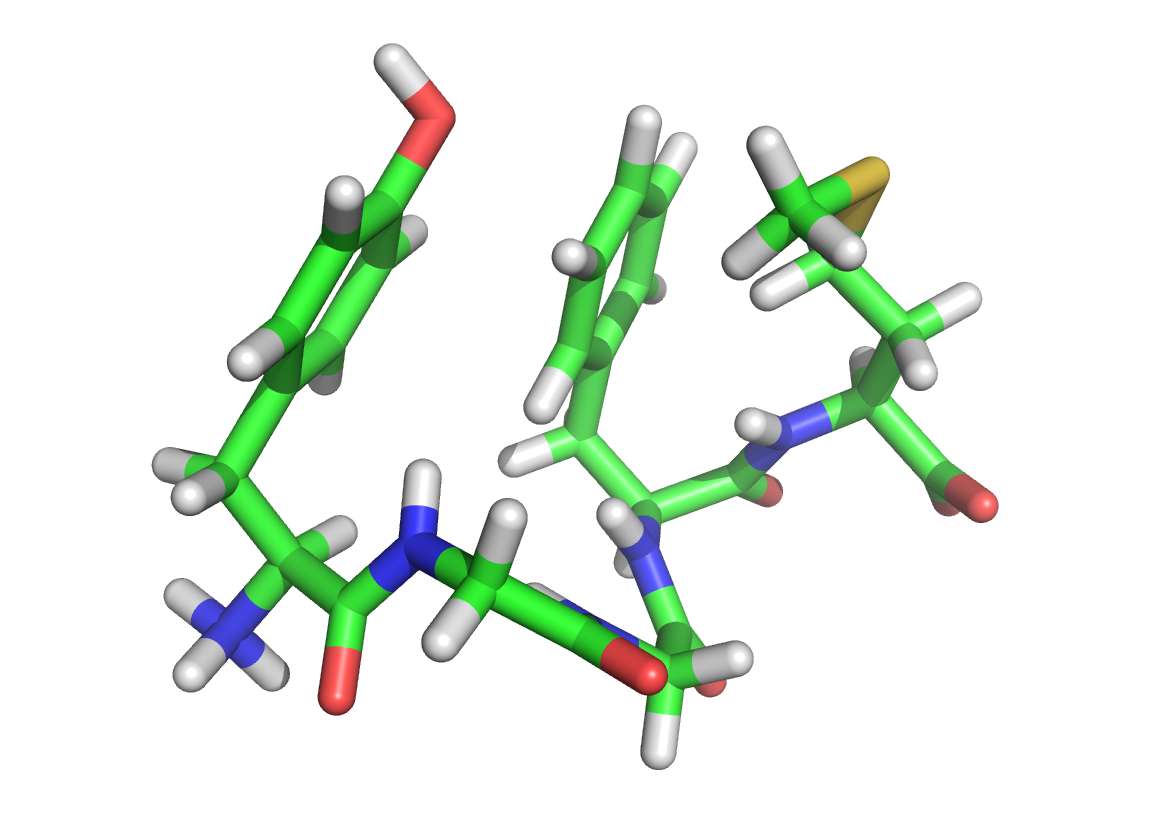

In [2]:
Image(filename='Met_struct.png', width=400)

and two trajectories of the V3-loop of HIV-1 (35 amino acids, closed by a di-sulfide bridge) simulated with Gromacs v4.6.5

    V3_Gromacs1_stripped.xtc
    V3_Gromacs2_stripped.xtc
    V3_Gromacs1_stripped.pdb
    V3_Gromacs2_stripped.pdb
    
are stored in 

> Trajectories/

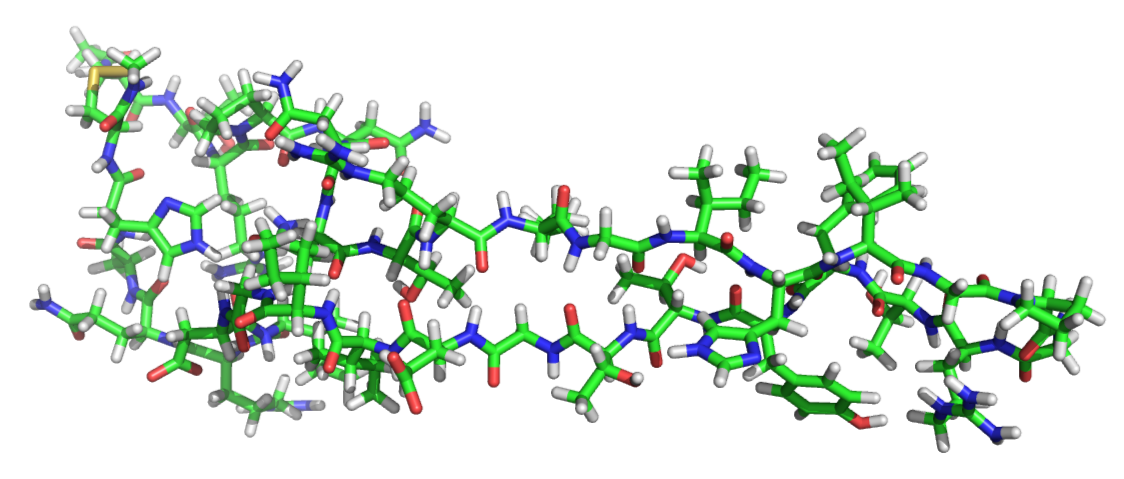

In [3]:
Image(filename='V3_struct.png', width=800)

## 2. RMSD matrices

One is able to assess the sampling quality without a Gromacs or Amber installation, only using the Python tool. Then, it is necessary to generate RMSD matrices (or distance based matrices) by hand (with Python or another MD simulation analysis tool). 

RMSD matrices must be generated for every trajectory separately. Additionally, one must also generate RMSD matrices for every unique trajectory pair combination. Thus, one obtains a block matrix representation of the full RMSD matrix concatenating all trajectories. The algorithm searches for the following names:

1. if the trajectories are called

        ExampleName1.ending
        ExampleName2.ending
        ... ,
    
1. then the RMSD matrices have to be generated as

        ExampleName1_bin.dat
        ExampleName2_bin.dat
        ExampleName1_ExampleName2_bin.dat
        ... .

Using gromacs or Amber trajectories, the algorithm supports the generation of RMSD matrices (and references for the effectiveClustering) using gromacs or AmberTools (full support checked for gromacs v4.6.7 and AmberTools14).

# III. Syntax and applications

The full analysis can be done either on __command line__, 
    
1. generating default configuration files,
1. add all necessary parameters per hand
1. and re-submit the full configuration files,

or __importing the modules in IPython__ directly. 

The following modules/functions are available and will be presented, which are ordered in three main blocks:

- Overlap calculation

> Generate_RMSD_Matrices()

> determineR_using_RMSD_distributions()

> Generate_EventCurves()

> Calc_Overlap()

- Clustering

> Generate_Clustering()

> Merge_Clustering_different_Thresholds()

> Generate_Centers_GLOBAL_singles()

> Generate_CDE_to_File()

> Generate_Slope_Error()

- Visualization

> Plot_ClusterProfile()

> Plot_Slope_Error_Plateau_NrClust()

> Plot_Overlap_VS_Threshold()

> Plot_HeatMap_1vs1()

> Plot_HeatMap_as_Dendro()

> Plot_Overlap_VS_Time()


The __first example__ will be done using the command line representation. The general syntax is

> python ../PySamplingQuality.py -module GenerateIn -in MODULE -out CONFIGFILE.in

> python ../PySamplingQuality.py -module MODULE     -in CONFIGFILE.in

The __second example__ will be done importing the modules. The generatl syntax is

> import MODULE

> MODULE(options)

# IV Generating the configuration files on command line and run the analysis

The configuration files contain all necessary variables for the calculation with short descriptions of them and the corresponding module. Additionally, the format syntax is indicated. All default values are automatically assigned.

Required variables have to be passed within quotes.

Afterwards, the complete configuration files are passed to generate the analysis.

## 1. Overlap calculation

For the Overlap calculation, first the RMSD matrices are generated, then the RMSD distributions are monitored to get an overview about relevant RMSD thresholds, for which the EventCurves and finally the Overlap are calculated for. Afterwards the EventCurves for every trajectory and finally the overlap is calculated.

The full details about the EventCurves and the Overlap definition can be found in the paper. In short: for every (reference) trajectory frame, the number of structures (events) of a certain trajectory within the threshold r-neighborhood is monitored in EventCurves. The mixture, if different trajectories can be found in the same r-neighborhood, is processed into two Overlap values: the conformational overlap, if at least one occurence of all trajectories can be found and the density overlap, if the density is similar for the r-neighborhoods of different reference frames.

We need to

1. generate RMSD matrices of all trajectories and (unique) trajectory pairs
    - investigate the RMSD distributions of all trajectories
1. calculate the EventCurves
1. and finally calculate the overlap (conformational | density).

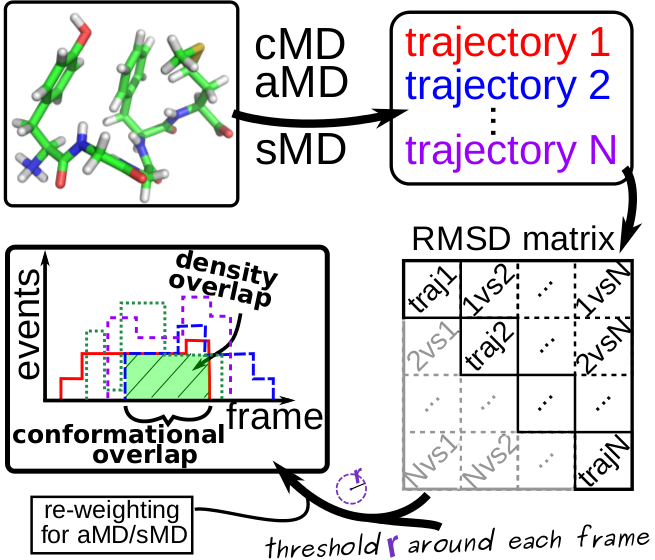

In [4]:
Image('OverlapCalculation.png', width=500)

### a) Generate configuration files

For the four steps to generate the overlap, we need at least four configuration files, which are generated by:

> python ../PySamplingQuality.py -module GenerateIn -in Generate_RMSD_Matrices -out ConfigFiles/Met_RMSDmat.in

> python ../PySamplingQuality.py -module GenerateIn -in determineR_using_RMSD_distributions -out ConfigFiles/Met_RMSDdist.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_EventCurves -out ConfigFiles/Met_Events.in

> python ../PySamplingQuality.py -module GenerateIn -in Calc_Overlap -out ConfigFiles/Met_Overlap.in

We will in total generate two additional files for the eventcurves and the overlap using different simulation time setups to analyze the influence of the simulation length.

> python ../PySamplingQuality.py -module GenerateIn -in Generate_EventCurves -out ConfigFiles/Met_Events2.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_EventCurves -out ConfigFiles/Met_Events3.in

> python ../PySamplingQuality.py -module GenerateIn -in Calc_Overlap -out ConfigFiles/Met_Overlap2.in

> python ../PySamplingQuality.py -module GenerateIn -in Calc_Overlap -out ConfigFiles/Met_Overlap3.in

First, we will take a detailed view into the first configuration file, to get an overview about the syntax and structure. Then, we will discuss the most relevant options and finally we will generate all files using the prepared configuration files.

Here, for simplicity, we generate first all configuration files and then run the analysis at once, although it is recommended to run first the RMSD distribution analysis because it gives insight into which thresholds $r$ should be used for the further overlap analysis.

### b) Explicit example of the configuration files for the RMSD matrix generation Met_RMSDmat.in

The commands above generate configuration files in 

    ConfigFiles/

and they even generate directories, which do not exist. The configuration files have all the same structure, which is visualized for __Met_RMSDmat.in__:

##### 1. header

The header contains always the information, for which module (__Generate_RMSD_Matrices()__) the configuration file was generated with a short descritption, that 

1. all default parameters are already set, 
1. all variables have to be enclosed by quotes
1. and that the format is given for every variable as a short example.

This is followed by the description of the module itself, containing the __version__ and necessary information.

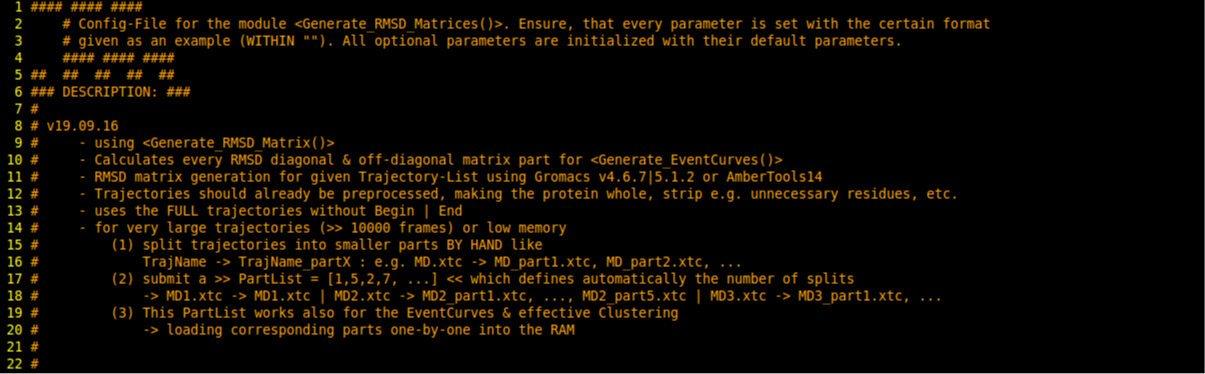

In [3]:
Image(filename='Config_Header.png', width=1000)

##### 2. default and required parameters

---
__NOTE:__

- __Double quotes have to enclose every parameter.__
        
        ""
        
- __An empty parameter/blank space is assumed as a set parameter. For a string, it generates a blank space.__

        " "
        
- __An empty string (e.g. for no directory changes or AMBERHOME) is submitted without blanks but single quotes enclosed by double quotes.__

        "''"
        
- __Default empty strings do not have to be changed, since they are assumed to be empty strings. E.g.__

        Program_Suffix = "''"
        
---

The header is followed by the parameters, which have to be set by hand, if no default value is present.



For the __example of the RMSD matrix generation__, the last five values are automatically set by default. They contain the options

1. setting an AmberHome variable to find the analysis tool __cpptraj__
1. setting a GromacsHome variable to find the analysis tool __g_rms / gmx rms__
1. to switch between __fitting__ all structures on top of each other before RMSD matrix calculation or not
1. setting an possible __suffix__ to the Gromacs analysis modules (see: Gromacs installation http://www.gromacs.org/Documentation/Installation_Instructions_4.6)
    - if you did not specify a suffix during the Gromacs installation, for Gromacs v4.6.7 your modules should be called e.g. 
            
            g_rms         ->   Program_Suffix = "''"
    - if you did specify a suffix, they should be called e.g. 
        
            g_rms_suffix  ->   Program_Suffix = "_suffix"
        
1. and tell the program, if trajectories are __split into different parts__ due to memory reasons.

__By default__, it is assumed, that the Home-variables are set in your environmental variables, the structures are fit using translational and rotational superposition, (a possible) gromacs installation does not contain any further program suffix and that the trajectories are not split. These parameters can be left unchanged in our example, except that the path of AmberHome is set explicitely.

The __Fit__ is usually done, if the whole protein is part of the overlap analysis, i.e. the structure conformations are the indicator, how well the protein is sampled. In this example, it shall be detected, if the single protein system is sampled sufficiently. For a complex system of multiple proteins or a protein-ligand system, it might be more relevant, to detect the attachement of the ligand binding. Such a complex question can for instance be addressed by transforming the system beforehand, that the full system (protein-ligand) is manually superimposed only on the $C_{\alpha}$-atoms of the protein, then the ligand is extracted, and RMSD matrices are generated finally setting the __Fit__-parameter to 'None' selecting only a small representative subset of ligand atoms. Then the intrinsic distances to the protein are still represented in the RMSD matrices and one can monitor the ligand binding during the sampling process.

Additionally, they are __nine parameters, which have to be set__ by hand. In this example, there are strings, an int/float and a list, which have to be set. The parameter types are given in angle brackets. 

Strings, ints and floats are just inserted as they are. Lists are always separated by a free space (e.g. "Name1 Name2 Name3 Name4") whereas lists with only one input does not contain a free space. They are always format examples in the same line as the parameter.

Furthermore, every parameter has an __own description__ and always a __specific example__, how a correct input will look like.

__In this example__, there are four directories, a list of trajectory names, the structure topology name, a timestep, which frames of the trajectories are taken into account and two selections, which atoms are used for the RMSD calculation.

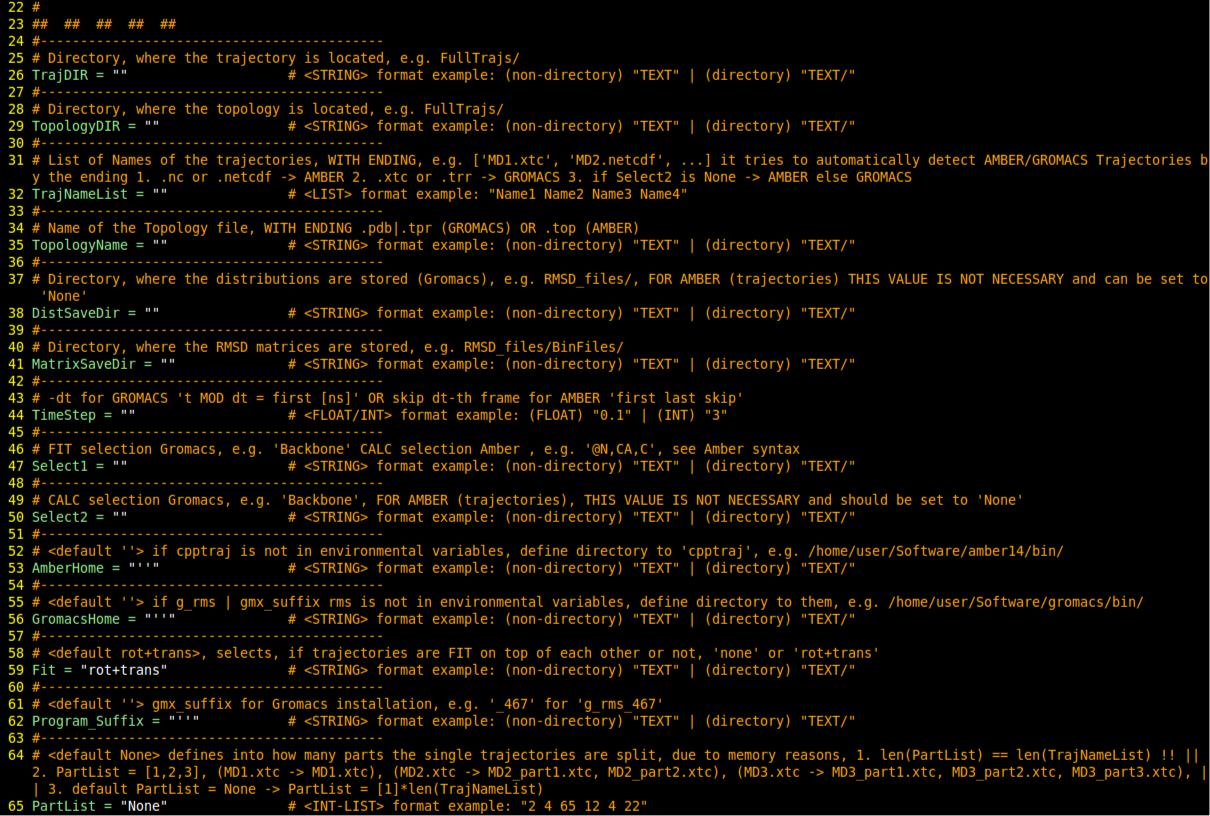

In [6]:
Image(filename='Config_Parameters.png', width=1000)

##### 3. complete configuration file

Here, the trajectories and topology file are located in 

    Trajectories/
    
and the RMSD matrices are stored in 

    RMSD_matrices/
    
The trajectories were pre-processed, thus we now use every time frame of the trajectory setting

    TimeStep = "1"
    
and using only the backbone atoms ($N, C_{\alpha}, C$) for the RMSD calculation.

Note, that the topology and the trajectory names are submitted with their endings, which information is given in the corresponding parameter descriptions. This is not always the case, but at this place, it is necessary, because the program tries to detect automatically gromacs trajectories (.xtc or .trr) and Amber trajectories (.netcdf or .nc).

Furthermore, directories are always submitted with their corresponding slashs.

Now, the configuration file is complete and can be used for the file generation.

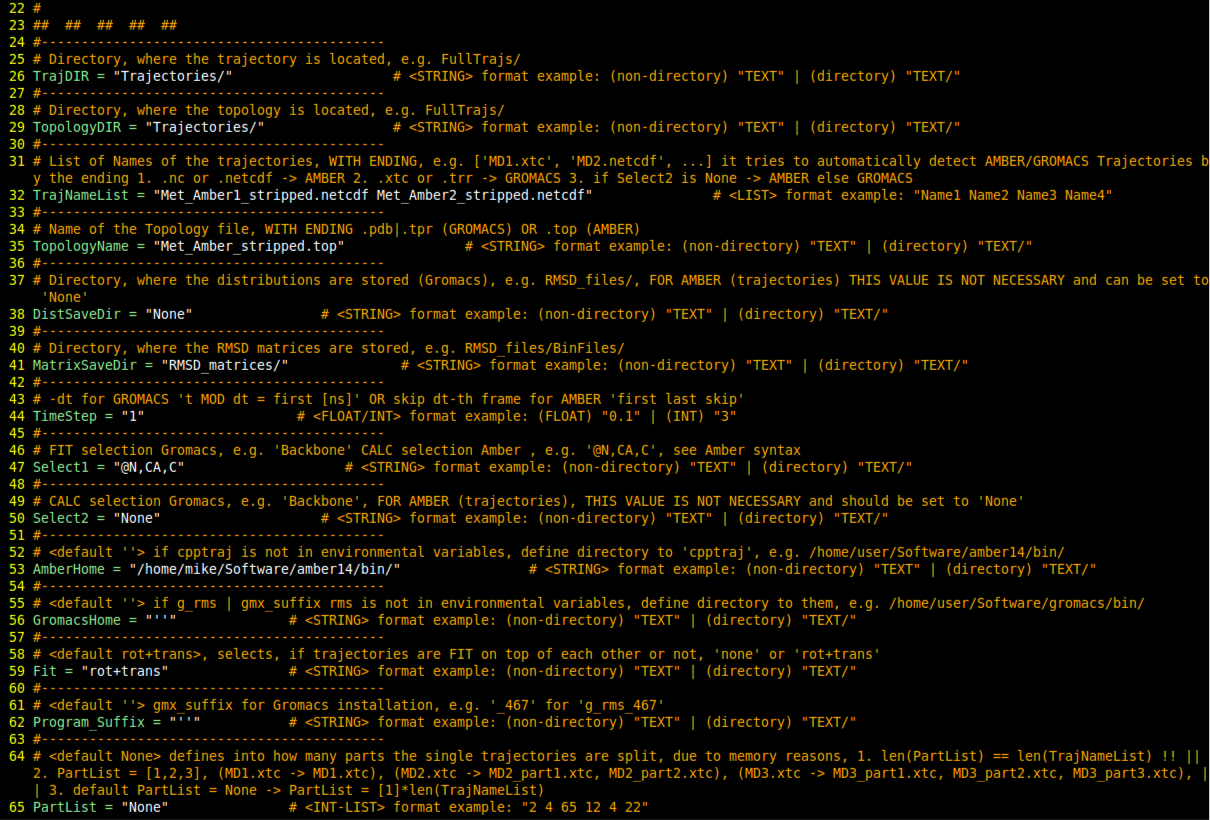

In [7]:
Image(filename='Config_Complete.png', width=1000)

### c) Relevant options for the other configuration files

##### 1. Met_RMSDdist.in

The configuration file for the RMSD distribution analysis can be filled straight-forward. We only change the __Percent__ parameter to __0.99__, to obtain the limits which describes 99 %% of the amount of the RMSD values. Both 0.05 %% tails are treated as outliers.

##### 2. Met_Events.in, Met_Events2.in, Met_Events3.in

For the eventcurve generation, we use a thredholdlist of

    ThresholdList = "0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4"
    
which are relevant parameters with respect to the RMSD distributions shown below. The lengths of both trajectories are 1000 frames each.

Then, there are two further necessary parameters __MaxNumberLines__ and __BinFile_precision__. MaxNumberLines directly inflicts the memory usage because it defines how many lines of the RMSD matrix (blocks) are loaded at once. Because the RMSD matrices have only a size of 1000x1000, it can be loaded completely, setting __MaxNumberLines = "1000"__

The parameter __BinFile_precision__ represents for gromacs trajectories the format type of the generated RMSD matrices in binary format, i.e. "float32" for a single or "float64" for a double precision installation. Here, we use only Amber trajectories, thus this value has to be set to "None".

Furthermore, we want to investigate three different simulation time lengths, 30ns, 60ns and 100ns. Thus one has to change __StartFrame__ and __EndingFrame__ to the corresponding values. The trajectories contain each 100ns and 1000 frames, whereas the default value "NP.infty" always takes the full trajectory. Thus we set for the free configuration files 

    StartFrame = 0,   EndingFrame="NP.infty"
    StartFrame = 0,   EndingFrame="600"
    StartFrame = 0,   EndingFrame="300"
    
which refer to simulation time lengths of 100ns, 60ns and 30ns starting always from the beginning of the trajectory.

All other values are either self-explanatory or only necessary for re-weighting, if enhanced sampling algorithms (aMD [Hamelberg et al. JCP120 2004, Sinko et al. JCTC 8 2012] or scaledMD [Sinko et al. JPCb 117 2013]) were used. Then one has to specify, which of the submitted trajectories was sampled with enhanced sampling algorithms (numbering starting from 1) and also specify, where possible aMD.log files from Amber are located, or which re-scaling factor $\lambda$ was used for scaledMD trajectories.

##### 3. Met_Overlap.in, Met_Overlap2.in, Met_Overlap3.in

Finally, the configuration files for the overlap contain only one complicated parameter, which is the __CompareList__. This defines the list, which trajectories are compared with each other. It is possible, to use groups of trajectories, if one wishes to compare multiply concatenated trajectories with another subset. These trajectories must be enclosed by the first square brackets, meaning that the eventcurves for these trajectories are combined. The second (round) brackets, defines which groups are compared with each other, for instance the overlap can be calculated between group1 vs group2 vs ... vs groupN. The last square brackets define, if multiple overlap analysis are done at once and stored in one file with multiple columns.

Here, we have only two trajectories, thus we calculate the overlap between the first and the second trajectory

    CompareList = "[([1],[2])]"

Furthermore, the parameter __EventNames__ must match the name of the eventcurve generated previously, and __AllPrject__ selects, if the overlap is calculated projecting all overlap groups on top of each other, or if the overlap value is monitored for every reference group separately. This is in detail explained in the paper, using different subsets of trajectories for the references and for the overlap calculation itself.

### d) Running the analysis and generate all files

Now, the files can be generated by 

> python ../PySamplingQuality.py -module Generate_RMSD_Matrices -in ConfigFiles/Met_RMSDmat.in

> python ../PySamplingQuality.py -module determineR_using_RMSD_distributions -in ConfigFiles/Met_RMSDdist.in

>> python ../PySamplingQuality.py -module Generate_EventCurves -in ConfigFiles/Met_Events.in

>> python ../PySamplingQuality.py -module Generate_EventCurves -in ConfigFiles/Met_Events2.in

>> python ../PySamplingQuality.py -module Generate_EventCurves -in ConfigFiles/Met_Events3.in

>> python ../PySamplingQuality.py -module Calc_Overlap -in ConfigFiles/Met_Overlap.in

>> python ../PySamplingQuality.py -module Calc_Overlap -in ConfigFiles/Met_Overlap2.in

>> python ../PySamplingQuality.py -module Calc_Overlap -in ConfigFiles/Met_Overlap3.in

which generates RMSD matrices

    RMSD_matrices/Met_Amber1_stripped_bin.dat
    RMSD_matrices/Met_Amber2_stripped_bin.dat
    RMSD_matrices/Met_Amber1_stripped_Met_Amber2_stripped_bin.dat
    
and the RMSD distributions beforehand

    RMSD_distributions/Met_Amber_dist.pdf

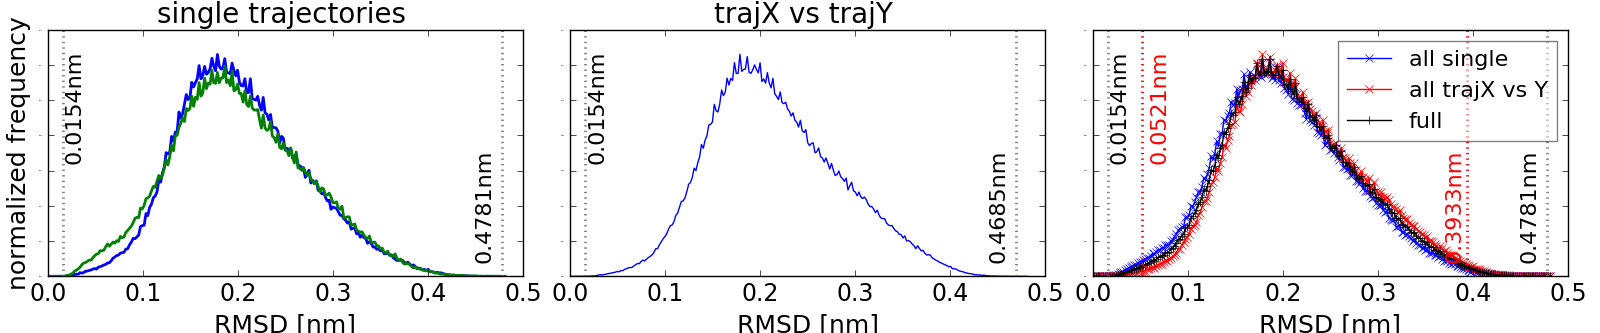

In [8]:
Image(filename='RMSD_distributions/Met_Amber_dist.png', width=1000)

The RMSD distributions of every single trajectory (left), of all trajectory pairs (middle) and the concatenated cases (right) give insight which thresholds for the overlap calculation or cluster generation are relevant. Here, the largest frequency is at RMSD = 0.2nm, showing that there are a lot of structures separated possibly forming independant clusters. Furthermore, below a threshold of $r < 0.05$nm, the overlap is trivially zero, and $r > 0.4$nm, the overlap must be 1. Thus the threshold $r$ should be set to a relevant value in the first half of the RMSD distribution curves, to obtain a good resolution, which is not too fine ($r < 0.05$nm) and not too coarse ($r > 0.4$nm).

The eventcurves 

    EventCurves/Met_Amber_0-1000_noWeight.npy
    EventCurves/Norm_Met_Amber_0-1000_noWeight.txt
    EventCurves/Met_Amber_0-600_noWeight.npy
    EventCurves/Norm_Met_Amber_0-600_noWeight.txt
    EventCurves/Met_Amber_0-300_noWeight.npy
    EventCurves/Norm_Met_Amber_0-300_noWeight.txt
    
are stored alongside with the normalization files, which contain the amount of involved frames for each trajectory, if the trajectory must not be re-weighted. The events as a function of the frames are stored in a python binary format, and can be loaded in python via

    numpy.load('EventCurves/Met_Amber_0-1000_noWeight.npy') .

In [9]:
EventCurve1 = numpy.load('EventCurves/Met_Amber_0-1000_noWeight.npy')

print EventCurve1.shape
print EventCurve1

(2000, 18)
[[   0    1    1 ...,  778  993  983]
 [   1    1    1 ...,  997 1000 1000]
 [   2    1    1 ..., 1000 1000 1000]
 ..., 
 [ 997    2    0 ...,  992 1000 1000]
 [ 998    2    2 ...,  974 1000  999]
 [ 999    2    1 ...,  999 1000 1000]]


The eventcurves contain the same values in their rows as the normalization factors, which is stored in txt-files. The first column refers to the frame of a given trajectory, the second column means the trajectory number numbered consecutively. The third to last columns are always storing the number of events for trajectory 1 - n for each threshold in ascending order. Thus one can plot event profiles for both trajectories.

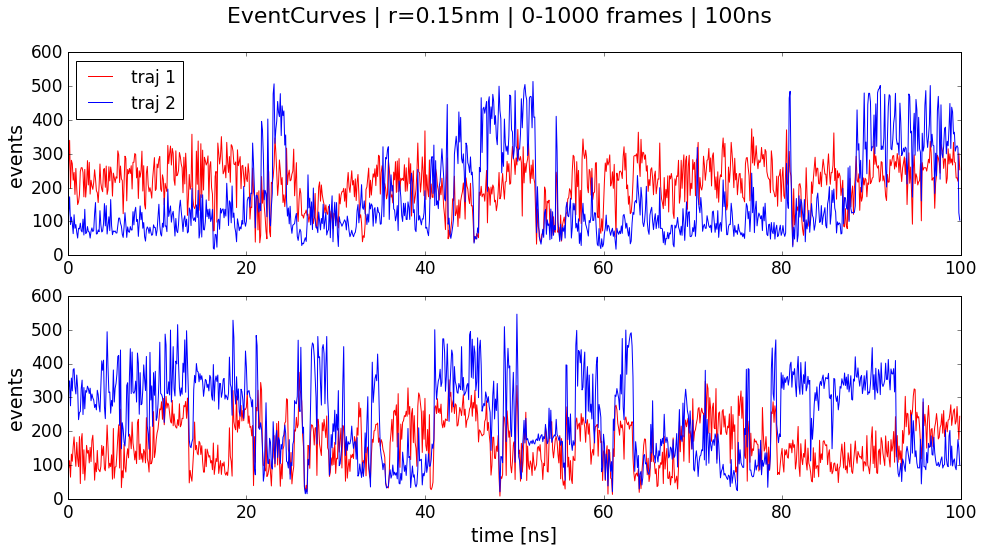

In [10]:
fig = plt.figure(figsize=(16,8));
plt.suptitle('EventCurves | r=0.15nm | 0-1000 frames | 100ns', fontsize=22);
plt.subplot2grid( (2,1), (0,0) );
plt.plot(EventCurve1[0:1000,0]/10., EventCurve1[0:1000,6], 'r-'); plt.yticks(fontsize=17); plt.xticks(fontsize=17);
plt.plot(EventCurve1[0:1000,0]/10., EventCurve1[0:1000,7], 'b-'); plt.ylabel('events', fontsize=19);
plt.legend(['traj 1', 'traj 2'], fontsize=17, loc=0)
plt.subplot2grid( (2,1), (1,0) );
plt.plot(EventCurve1[1000:2000,0]/10., EventCurve1[1000:2000,6], 'r-'); plt.yticks(fontsize=17);
plt.plot(EventCurve1[1000:2000,0]/10., EventCurve1[1000:2000,7], 'b-'); plt.ylabel('events', fontsize=19);
plt.xticks(fontsize=17); plt.xlabel('time [ns]', fontsize=19);

The event profiles give an insight about, how the trajectories are distributed over the simulated conformations, but also give information about where are large or low potential areas (probably) located. The figures show the event curves for both trajectories at r=0.15nm whereas the x-axis shows the reference frames of trajectory 1 (top) and trajectory 2 (bottom). The events give the number of neighbors in the r-neighborhood for the corresponding trajectory with respect to the specific reference structure here denoted as a certain time point of the simulation.

One can see, that on some parts, both curves have the same density of points around the reference, and that there seem to be a large potential at around simulation time 47ns (upper figure) and 28ns (lower figure), where both trajectories have only few events. But one can also identify regions, where the sampling is not perfect and the number of events deviate between both trajectories.

The overlap results are stored in 

    Overlap/Overlap_Met_Amber_0-1000_noWeight.txt
    Overlap/Overlap_Met_Amber_0-600_noWeight.txt
    Overlap/Overlap_Met_Amber_0-300_noWeight.txt
    
for different simulation time lengths. The format of the files are, that it is reported, on which trajectory subgroups the eventcurves are projected of the CompareList selection and the overlap is calculated (first column). Here, the overlap refers on the projection on both reference groups. The second column defines the threshold. Afterwards, there are three values for every different overlap calculation defined in the header:

1. normalized density overlap
1. number of (reference) frames, where at least one event of all involved trajectories is present
1. total number of (reference) frames

The conformational overlap is then the ratio of the second and the third value.

The overlap results are visualized below using the present plotting modules.

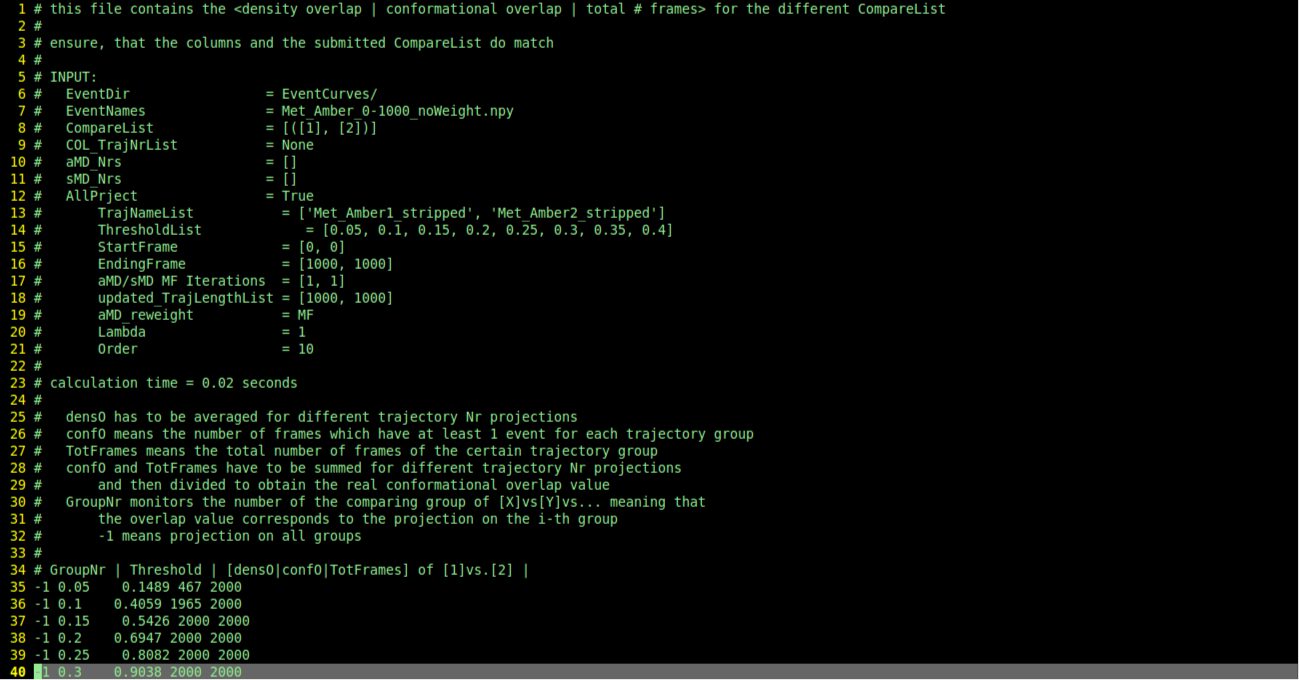

In [11]:
Image('OverlapFile.png', width=1000)

## 2) Clustering

The effectiveClustering uses the generated RMSD matrices by Generate_RMSD_Matrices(). Additionally, it is possible, to submit a reference structure (e.g. a crystal structure), to which the RMSD values are calculated. Then the closest structure to this reference is taken as starting point (first centroid) of the clustering. Otherwise, the first frame of the first trajectory is used. 

The algorithm is descriped in detail in the paper. In short, the structures are partitioned based on the RMSD values: Centroids are assigned by the threshold r, i.e. all formerly defined centroids are merged together, and the next structure outside the threshold r is then the next centroid. Afterwards, after all centroids are assigned, all unassigned structures are assigned to the cluster of the closest centroid.

The clustering can either be done for every trajectory separately (Local), or on all concatenated trajectories (Global). Then, single clustering for each trajectory can be extracted detecting all centroids where at least one structure of the corresponding trajectory is present.

Afterwards, the cluster vs. time and cluster distribution entropy vs. time can be visualized.

Every clustering depends on a specific threshold r, which are not calculated at once because it is not easily parallelizable. Clustering files with different thresholds r can be merged together to be analyzed at once.

We will generate the following analysis:

1. cluster the trajectories (threshold r = 0.1nm)
1. cluster the trajectories (threshold r = 0.15nm)
1. merge both clusterings together into one file
1. extract single trajectory clustering from the (Global) concatenated trajectory case
1. extract the Cluster Distribution Entropy (CDE) and Nr of Clusters vs. simulation frames
1. calculate the slopes for the CDE and Nr of Clusters vs. simulation time

## a) Generate configuration files

To run the clustering, we will produce six configuration files by:

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Clustering -out ConfigFiles/Met_Cluster_R0.1.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Clustering -out ConfigFiles/Met_Cluster_R0.15.in

> python ../PySamplingQuality.py -module GenerateIn -in Merge_Clustering_different_Thresholds -out ConfigFiles/Met_Merge.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Centers_GLOBAL_singles -out ConfigFiles/Met_GLOBAL_singles.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_CDE_to_File -out ConfigFiles/Met_CDE.in

> python ../PySamplingQuality.py -module GenerateIn -in Generate_Slope_Error -out ConfigFiles/Met_Slope.in

Here, we will generate two clusterings with threshold $r=0.1$nm and $r=0.15$nm using the full trajectories. Both trajectories are clustered at once, meaning that effectively they are concatenated and a global partition will be applied. This allows one to compare the results and number of found clusters clearly. Additionally, we apply for demonstration reasons a reference PDB structure, which is in fact the starting structure for the second trajectory. Thus, we already know, that the 1001st structure will be the first cluster centroid, which can be verified in the clustering profiles.

Afterwards, both clustering files will be merged to obtain one file for all/both threshold parameters. One only needs to ensure, that the input in __Met_Merge.in__ match the clustering file names.

Then, single clusterings are extracted from the global clustering, which involves all concatenated frames of all involved trajectories. 

The cluster distribution entropy (CDE) will also be extracted from the global clustering profile, with selecting the __Case = "GLOBAL_singles"__ to calculate the CDE for every trajectory separately, but using the global partitioning. To investigate only single trajectories, it is also possible to calculate a clustering for every trajectory separately, and then calculate the CDE, to obtain the best unique partitioning just for one trajectory.

The slopes then uses the CDE file to calculate the slopes for the last three frame cases specified by the __SlopeTimeArray__ parameter. Note, that the argument symbolizes number of frames, not a specific time. Additionally, the __X_NormFactor__ normalizes the x-axis, corresponding to the frames respectively to the simulation time. A factor of __1000__ (default) means, that the CDE or number of clusters is assumed to raise in the next 1000 steps by the calculated slope.

### b) Running the clustering and generate all files

The clustering is generated by 

> python ../PySamplingQuality.py -module Generate_Clustering -in ConfigFiles/Met_Cluster_R0.1.in

> python ../PySamplingQuality.py -module Generate_Clustering -in ConfigFiles/Met_Cluster_R0.15.in

for two different thresholds $r$ and then merged into one file by 

> python ../PySamplingQuality.py -module Merge_Clustering_different_Thresholds -in ConfigFiles/Met_Merge.in

One obtains beforehand an RMSD curve for all concatenated trajectories with respect to the reference, which is in this case simply the first structure of the second trajectory. Thus the RMSD value to this (1001st) frame is zero and will be taken as first centroid. 

There are two files which store the clustering results: First, the clustering profile is stored, which gives information, which cluster the specific frame belongs to (__PROF__), with the corresponding distances, next closest centroid (__nextC__) and the farthest centroid (__farthC__). 

    Clustering/Met_Amber_R0.1-0.15_0-1000_GLOBAL.txt    

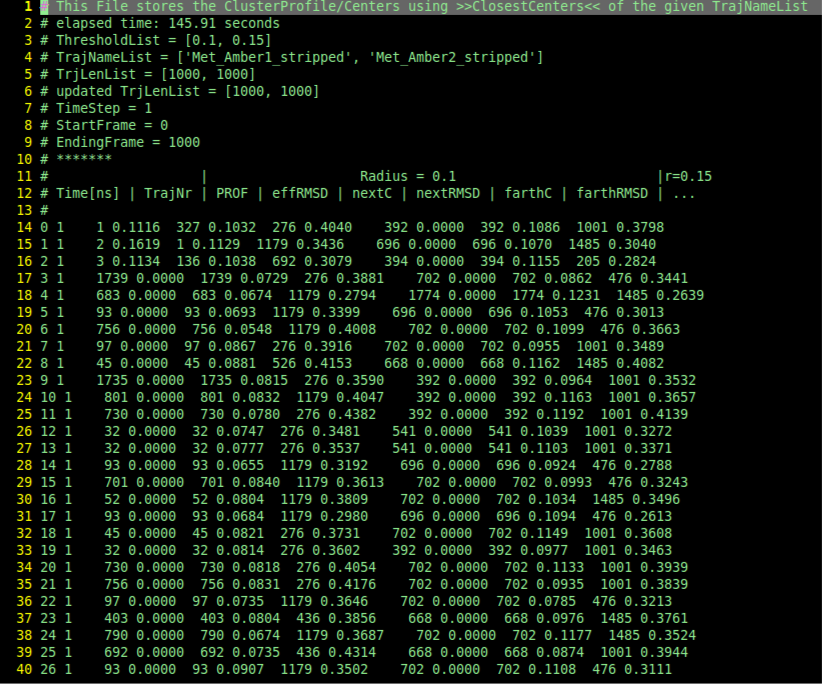

In [12]:
Image('ClusterProfile.png', width=700)

Second, the number of clusters and the corresponding cluster centroids are stored in

    Clustering/Met_Amber_R0.1-0.15_0-1000_Centers_GLOBAL.txt .

In the latter file, one can see that the 1001st frame indeed is the first detected centroid, and that there are detected 164 clusters for $r=0.1$nm and 23 clusters for $r=0.15$nm combining both trajectories.

Clusterings for each trajectory are extracted by

> python ../PySamplingQuality.py -module Generate_Centers_GLOBAL_singles -in ConfigFiles/Met_GLOBAL_singles.in

whereas only the centroid file is generated, which contains the information which and how many centroids do belong to the corresponding trajectory

    Clustering/Met_Amber_R0.1-0.15_0-1000_Centers_GLOBAL_singles.txt
 
the profiles stay unchanged.

Finally the CDE and the corresponding slopes are calculated

> python ../PySamplingQuality.py -module Generate_CDE_to_File -in ConfigFiles/Met_CDE.in

> python ../PySamplingQuality.py -module Generate_Slope_Error -in ConfigFiles/Met_Slope.in

obtaining
    
    Clustering/CDE_Met_Amber_R0.1-0.15_GLOBAL_singles.txt
    Clustering/Slope_Met_Amber_R0.1-0.15_GLOBAL_singles.txt
    
The CDE file contains the information, how many clusters are found in a certain simulation time and how the distribution entropy evolves. There are also normalized values for better comparison.

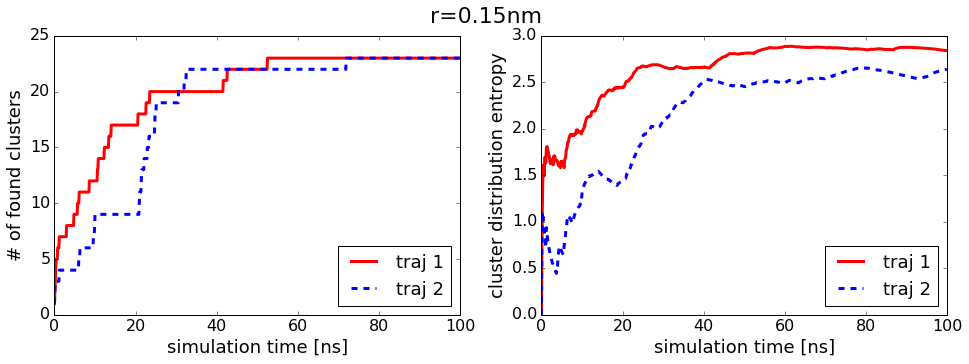

In [13]:
CDE = numpy.genfromtxt('Clustering/CDE_Met_Amber_R0.1-0.15_GLOBAL_singles.txt')

fig = plt.figure(figsize=(16,5))
#-----
plt.subplot2grid( (1,2), (0,0) ); plt.suptitle('r=0.15nm', fontsize=22)
plt.plot(CDE[0:1000,0]/10., CDE[0:1000,6], 'r-', lw=3); plt.plot(CDE[0:1000, 0]/10., CDE[1000:2000,6], 'b--', lw=3);
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('# of found clusters', fontsize=18); 
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);
#-----
plt.subplot2grid( (1,2), (0,1) )
plt.plot(CDE[0:1000,0]/10., CDE[0:1000,8], 'r-', lw=3); plt.plot(CDE[0:1000, 0]/10., CDE[1000:2000,8], 'b--', lw=3); 
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('cluster distribution entropy', fontsize=18); 
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);

One can see, that both trajectories do not express new clusters in the last part (50ns, 25ns), which could indicate, that the simulation converged. Also the cluster distribution entropy are almost constant for the first trajectory for about 40ns, but there are some minor changes in the second trajectory. This will be explicitely calculated plotting the slopes.

## 3. Plotting

There are several modules to plot some special cases of the overlap analysis and the clustering, showing directly the behavior of the sampling. 

One of them is the Overlap vs. Threshold plot, which should express a convex behavior between the two extreme thresholds $r_{\text{min}} < r < r_{\text{max}}$, where the overlap is zero respectively one due to a too low or too large threshold. The faster the curve reaches a large overlap (close to one), the better the sampling.

Another interesting figure is the overlap heatmap showing the pair overlap between all involved trajectories. This allows us also to detect outlying trajectories or detect similar groups of sampling.

Furthermore, the overlap vs simulation time should show convergence and allows one to extract the critical simulation time $t_{\text{crit}}$ which is necessary for a sufficient sampling. This also shows a trend, how long one should simulate if convergence is not reached.

For the clustering, one can automatically plot the slopes of the curves

1. cluster distribution entropy (CDE) vs simulation time [Sawle & Ghosh - JCTC 12 (2), 2016]
1. and number of clusters found vs simulation time.

Both should converge to a constant plateau with a slope close to zero. This is shown plotting the slopes for every trajectory with their 95 %% confidence interval for the last simulation parts. Additionally, one can display the time, how long all clusters are already found, to decide, if one expects the formation of new clusters.

There are much more interesting values one can monitor, like the number of clusters for each trajectory (found in the clustering files), or the number of clusters vs time curves (found in the cluster distribution files), or plotting the event curves as a function of the simulation time, as well, which are shown above. These are not part of the python tool, which aims to plot condensed information for (massively) multiple trajectories.

### a) Configuration files for plotting

The commands to generate the configuration files to

1. plot the overlap vs threshold
1. plot HeatMaps and corresponding cluster number for all trajectory pairs
1. plot HeatMaps as Dendrogram for all trajectory pairs
1. plot the overlap vs the simulation time
1. plot the clustering profile as a function of the time
1. plot the
    - slopes of the cluster distribution entropy (CDE) vs. time
    - slopes of the number of clusters vs. time
    - plateau size if all clusters are found, i.e. the simulation time when no further cluster was found

are the following:

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Overlap_VS_Threshold -out ConfigFiles/Plot_OvR.in

- using all overlap files with different simulation times
- adjusting the x-range to __XLIM1 = "0.05 0.3933"__ which are the 99%% from the RMSD distributions (see above)

> python ../PySamplingQuality.py -module GenerateIn -in Plot_HeatMap_1vs1 -out ConfigFiles/Plot_Heat.in

- using the 100ns overlap file
- adding the centroids from the extracted single trajectory but global clustering (__Centers_GLOBAL_singles.txt__)
- defining __Grid = "1"__, which makes a grid after the first trajectory, to separate both trajectories in the heatmap

> python ../PySamplingQuality.py -module GenerateIn -in Plot_HeatMap_as_Dendro -out ConfigFiles/Plot_Dendro.in

- using the same files as for the heatmap
- specifying the case to visualize only the density overlap

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Overlap_VS_Time -out ConfigFiles/Plot_OvT.in

- changing the StartFrame and EndingFrame to __Start-End__ in the overlap file, which automatically detects all simulation times specified in the __SimTimeList__
- using as __SimTimeList__ the three different simulation times, whereas the Start and End have to be specified

> python ../PySamplingQuality.py -module GenerateIn -in Plot_ClusterProfile -out ConfigFiles/Plot_Profile.in

- specifying the __TimeStep = "0.1"__ [ns] to translate the frames to the simulation time
- using __TrjLenList = "100 100"__, because the lengths of the trajectories are also in [ns] instead of frames

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Slope_Error_Plateau_NrClust -out ConfigFiles/Plot_EntropySlopes.in

- using the Slope file generated previously
- specifying again the __TimeStep = "0.1"__ [ns]

> python ../PySamplingQuality.py -module GenerateIn -in Plot_Slope_Error_Plateau_NrClust -out ConfigFiles/Plot_ClusterSlopes.in

For convenience, PNG files are generated and importet in this notebook. Usually, PDF files are generated on default.

### b) Plots and results

##### 1. Overlap vs. Threshold

The conformational, density and integrated overlap are calculated for all three simulation time overlap files. The integral corresponds to the area under the curve normalized by the displayed area. 

One can see, that the conformational overlap reaches a value of 1 very fast for small thresholds, whereas one can see the influence of the different simulation time lengths. Both trajectories cover the same conformational space.

The density overlap starts to show a convex behavior after 60ns. But still for such a small molecule, 100ns is not enough to reach high values of the density overlap at small resolution.

> python ../PySamplingQuality.py -module Plot_Overlap_VS_Threshold -in ConfigFiles/Plot_OvR.in

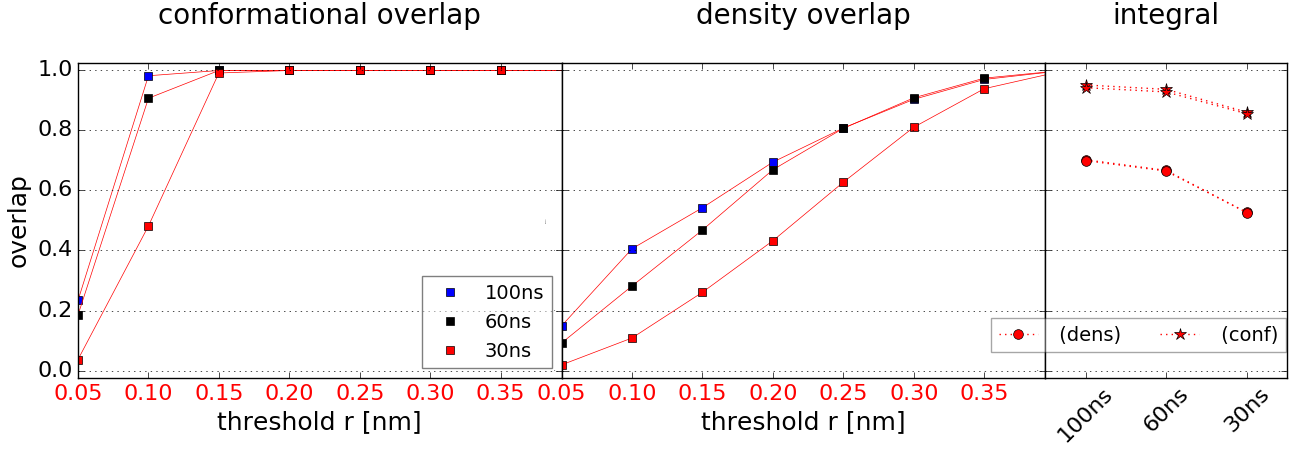

In [14]:
Image(filename='PDFs/Met_Amber_OverlaPvsThreshold.png', width=1000)

##### 2. Heatmap & Dendrogram

The heatmaps represents pair overlap between all trajectories. This is especially useful for massively multiple trajectory comparisons. Here, the values correspond to a threshold of $r=0.15$nm, thus the same values already shown in the Overlap vs Threshold case. Additionally, the number of found clusters for all trajectories can be visualized, if the specific centroid file is submitted.

There is a special option to generate the heatmaps (not shown here) to show the overlap projected only on one reference trajectory. This means, that the overlap between two trajectories is calculated for every (reference) frame of only one trajectory, which give insight about, how well two trajectories overlap only in the subset of one. This can be achieved, if the overlap is calculated with __AllPrject = "True"__, which has to be used also for the heatmap generation, as well. Then the heatmap matrix is asymmetric, i.e. the lower triangular matrix refers to the overlap XvsY projected on trajectory X, and the upper triangular projected on trajectory Y. 

This is for instance useful, to show if one trajectory show a trapped behavior in contrast to others. If a trapped trajectory is used as reference, one obtains a large conformational overlap comparing the trapped with a converged trajectory, because the converged trajectory reaches all the frames of the trapped one. The density overlap will also be larger, in contrast if the converged trajectory is used as reference. This is why both trajectories have to be evaluated as references to conclude, how sufficient the sampling is.

> python ../PySamplingQuality.py -module Plot_HeatMap_1vs1 -in ConfigFiles/Plot_Heat.in

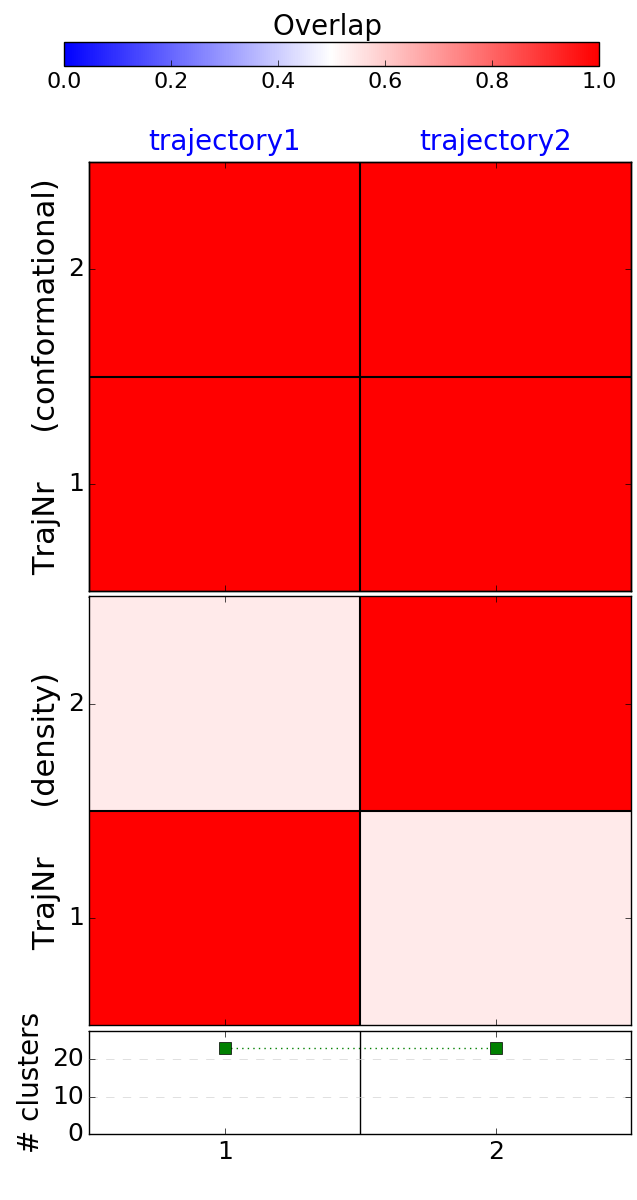

In [15]:
Image(filename='PDFs/Met_Amber_Heat.png', width=300)

The heatmap and corresponding found clusters show, that both trajectories are similar, and the most conformations are found, but the simulation time does not suffice to sample the correct density.

Additionally, the (symmetric) heatmap can be used as input to generate a hierarchically clustered dendrogram using average linkage, to obtain a relation tree representation of the pair overlap.

> python ../PySamplingQuality.py -module Plot_HeatMap_as_Dendro -in ConfigFiles/Plot_Dendro.in

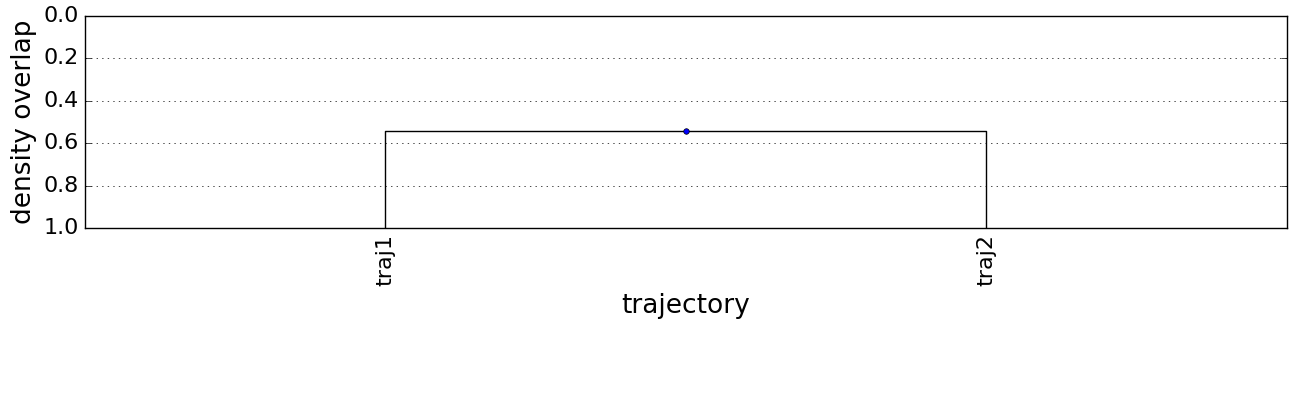

In [16]:
Image(filename='PDFs/Met_Amber_Dendro.png', width=1000)

##### 3. Overlap vs. Time

The overlap as a function of the simulation time is a good indicator, if the trajectories and the corresponding sampling already converged or is sufficient. To investigate this issue, the trajectories were splitted into three different simulation times 30ns, 60ns and 100ns and plotted for the resolution of $r=0.15$nm. 

One can also select different parts of the trajectories, e.g. the last 30ns by specifying __StartFrame__ in the overlap calculation and in the plotting configuration file.

> python ../PySamplingQuality.py -module Plot_Overlap_VS_Time -in ConfigFiles/Plot_OvT.in

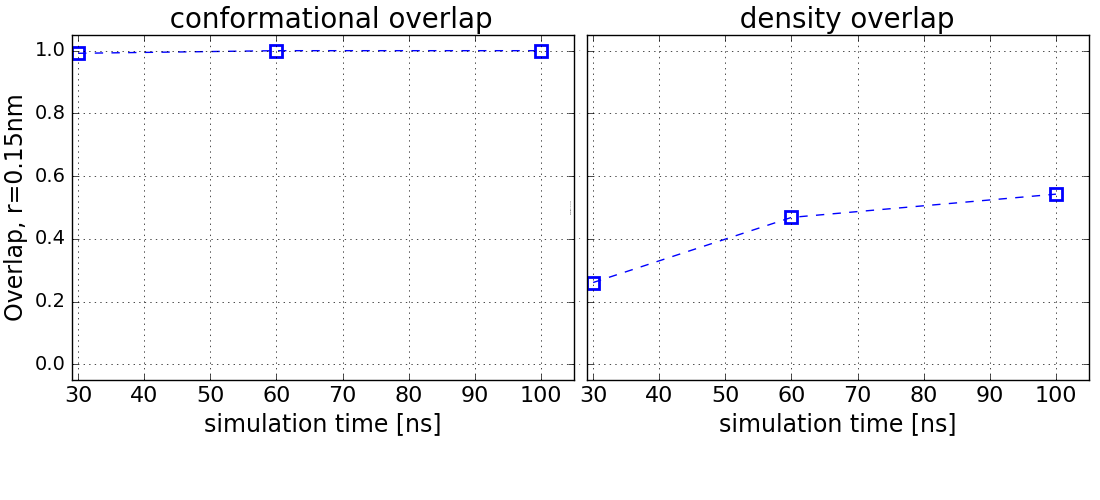

In [17]:
Image('PDFs/Met_Amber_OvT.png', width=1000)

The overlap as a function of the simulation time confirms that the most conformations are found, since the conformational overlap is 1. The density overlap is not converged, yet. Although, the curve seems to slowly converge due to the convex shape, this might be misleading, because using only 60ns may overestimate the density agreement, which can be seen in the event curves above. Thus in general, to obtain a density overlap of one with a high resolution (small $r$) might require very long simulation times, because this overlap value is a conservative measure not to overestimate the sampling quality. It might be sufficient, to obtain a high density overlap for small $r$ (not necessarily of 1) to obtain correct thermodynamic averages.

##### 4. Clustering Profile

A clustering profile can be obtained by plotting the clustering centroid as a function of the simulation time. This gives insight about the transitions and occurences of different clusters during the course of the simulation. The first and last occurence of a cluster during the simulation are marked with horizontal lines, squares mark the specific time if the corresponding cluster is visited and white crosses mark the time which the centroid corresponds to.

> python ../PySamplingQuality.py -module Plot_ClusterProfile -in ConfigFiles/Plot_Profile.in

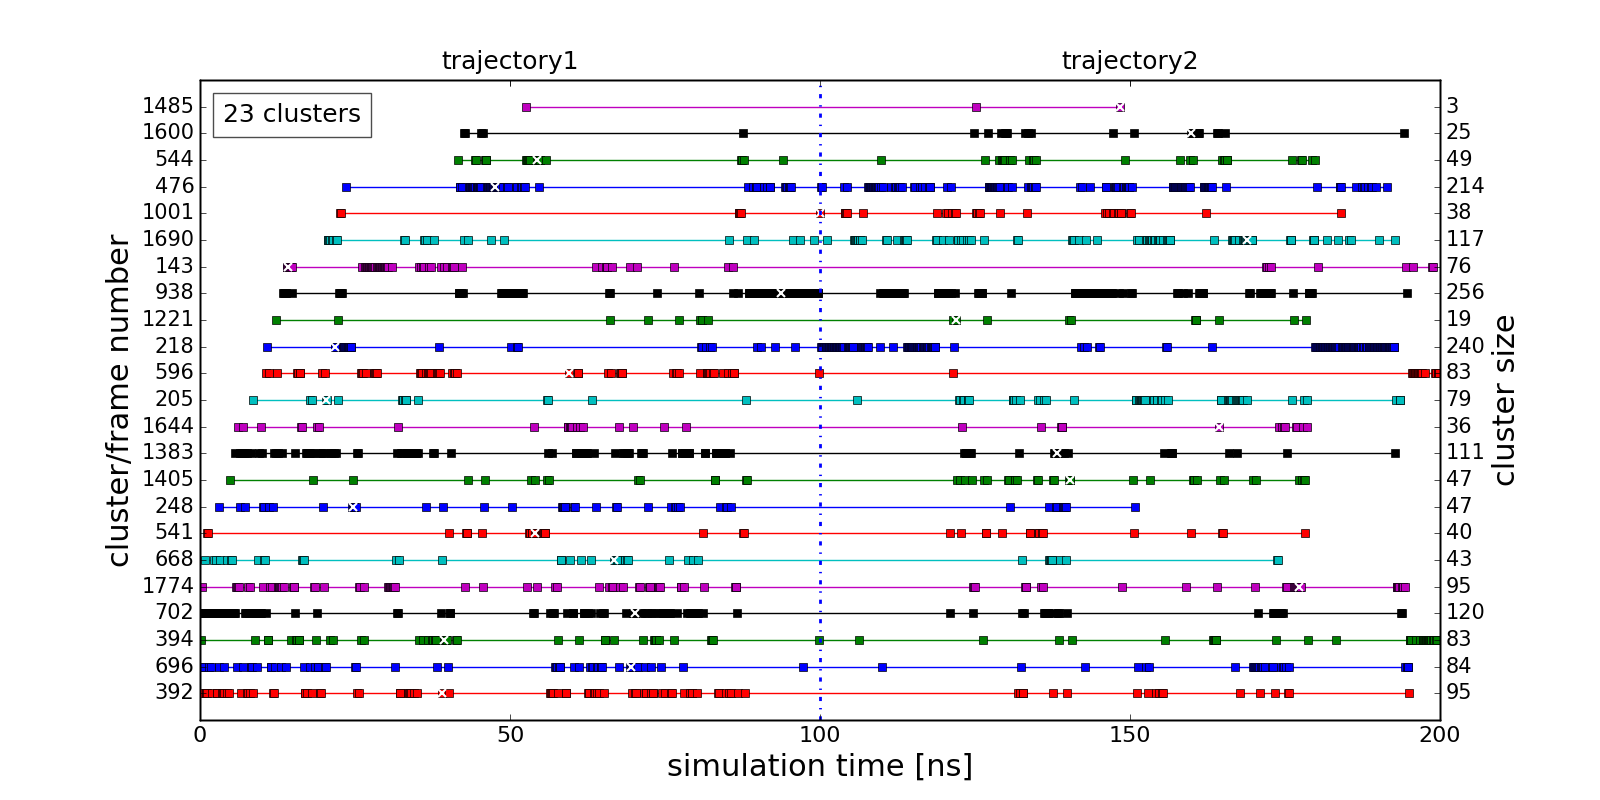

In [18]:
Image('PDFs/Met_Amber_ClusterProfile.png', width=1000)

One can see, that every cluster is found by both trajectories, although the density is not the same. Some clusters are only transition states, whereas others seem to be states with a low potential. But both trajectories expresses different distributions, which could also be shown in the event curves and overlap values.

##### 5. Slopes

The slopes of the number of clusters and CDE as a function of time (see above) can be extrated, to compare the tendency finding new clusters or getting a constant entropy value of multiple trajectories at once. The slopes are monitored for 

For the entropy slopes, large negative values indicate, that the trajectory is trapped, because only few of the total number of clusters are sampled for a long time. Large positive values might indicate, that the sampling for one trajectory is incomplete and one should assume to find new clusters for longer simulation times. 

The cluster slopes give insight about, if one should assume to find new clusters for longer simulation times. 

The slopes directly correlate with the __X_NormFactor__ defined above, i.e. here in 1000 steps the number of clusters or the CDE raises by the corresponding slope, which means here 100ns.

> python ../PySamplingQuality.py -module Plot_Slope_Error_Plateau_NrClust -in ConfigFiles/Plot_EntropySlopes.in

> python ../PySamplingQuality.py -module Plot_Slope_Error_Plateau_NrClust -in ConfigFiles/Plot_ClusterSlopes.in

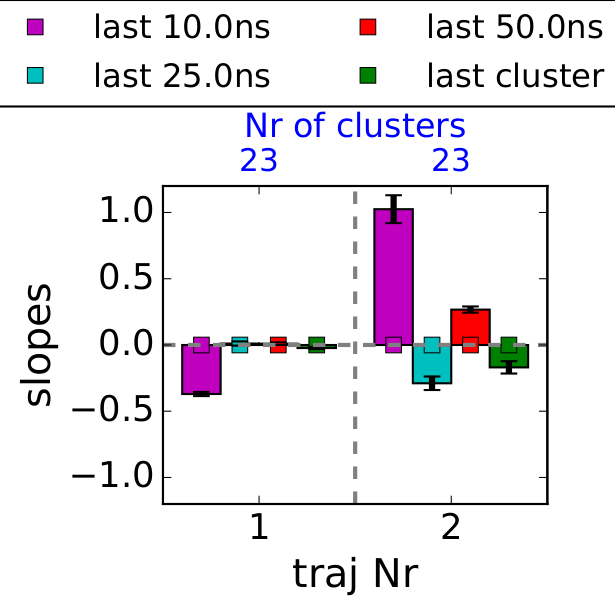

In [19]:
Image('PDFs/EntropySlope_Met_Amber_R0.1-0.15_GLOBAL_singles.png', width=300)

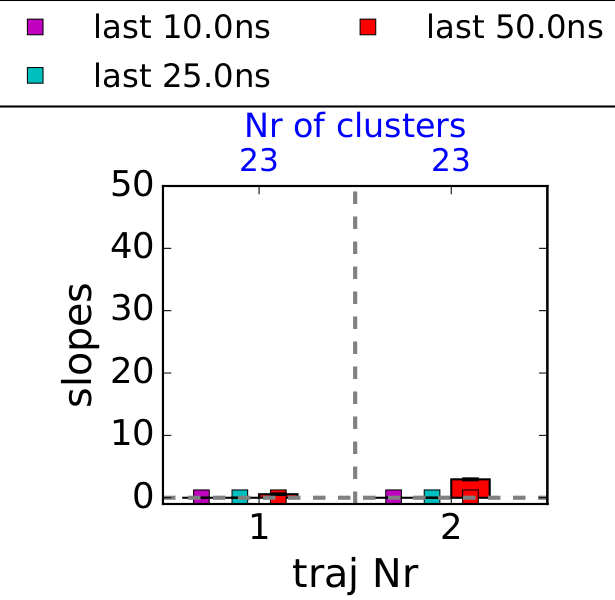

In [20]:
Image('PDFs/ClusterSlope_Met_Amber_R0.1-0.15_GLOBAL_singles.png', width=300)

---

# V. Generate the analysis in IPython

The whole analysis can also be done directly in __python__. For this, we will use this IPython notebook importing all necessary functions, and defining all necessary input options as variables. 

Since all functions are already introduced above, only the necessary parameters are explained.

## 1. Import necessary modules

All necessary modules can be loaded at once.

In [21]:
from PySamplingQuality import Generate_RMSD_Matrices
from PySamplingQuality import determineR_using_RMSD_distributions
from PySamplingQuality import Generate_EventCurves
from PySamplingQuality import Calc_Overlap

from PySamplingQuality import Generate_Clustering
from PySamplingQuality import Merge_Clustering_different_Thresholds
from PySamplingQuality import Generate_Centers_GLOBAL_singles
from PySamplingQuality import Generate_CDE_to_File
from PySamplingQuality import Generate_Slope_Error

from PySamplingQuality import Plot_ClusterProfile
from PySamplingQuality import Plot_Slope_Error_Plateau_NrClust
from PySamplingQuality import Plot_Overlap_VS_Threshold
from PySamplingQuality import Plot_HeatMap_1vs1
from PySamplingQuality import Plot_HeatMap_as_Dendro
from PySamplingQuality import Plot_Overlap_VS_Time

For further information about the input options and descriptions can be obtained in the __doc-strings__ of the corresponding module, which can be accessed via:

In [23]:
print Generate_RMSD_Matrices.__doc__

 
v19.09.16 
    - using <Generate_RMSD_Matrix()>
    - Calculates every RMSD diagonal & off-diagonal matrix part for <Generate_EventCurves()>
    - RMSD matrix generation for given Trajectory-List using Gromacs v4.6.7|5.1.2 or AmberTools14
    - Trajectories should already be preprocessed, making the protein whole, strip e.g. unnecessary residues, etc.
    - uses the FULL trajectories without Begin | End
    - for very large trajectories (>> 10000 frames) or low memory
        (1) split trajectories into smaller parts BY HAND like 
            TrajName -> TrajName_partX : e.g. MD.xtc -> MD_part1.xtc, MD_part2.xtc, ...
        (2) submit a >> PartList = [1,5,2,7, ...] << which defines automatically the number of splits
            -> MD1.xtc -> MD1.xtc | MD2.xtc -> MD2_part1.xtc, ..., MD2_part5.xtc | MD3.xtc -> MD3_part1.xtc, ...
        (3) This PartList works also for the EventCurves & effective Clustering
            -> loading corresponding parts one-by-one into the RAM

INPUT:
   

This is the same information, which is also contained in the configuration files.

Furthermore, all default parameters are set automatically, thus they do not need to be specified necessarily.

## 2. Overlap calculation

##### 1. RMSD matrices

The RMSD matrices are generated as before, but now Gromacs trajectories are used. 

In [24]:
Generate_RMSD_Matrices(TrajDIR='Trajectories/', TopologyDIR='Trajectories/', 
                      TrajNameList=['V3_Gromacs1_stripped.xtc', 'V3_Gromacs2_stripped.xtc'], 
                      TopologyName='V3_Gromacs2_stripped.pdb', DistSaveDir='RMSD_distributions2/', 
                      MatrixSaveDir='RMSD_matrices2/', TimeStep=0.1, 
                      Select1='Backbone', Select2='Backbone', 
                      GromacsHome='/home/mike/Software/gromacs-4.6.7-single/bin/')

The major change is the __TimeStep=0.1__ [ns] value. This means, that every 0.1ns are used starting from the first frame of the trajectory. Because the first frame is also used, there are __1001 frames__, although only 100ns are simulated. This has to be taken into account for the trajectory lengths

Additionally for simplicity, we use as a topology file a PDB structure, thus masses and parameters are automatically detected by the atom names in the PDB file. In general, it is useful to generate a run input file, see the gromacs manual and syntax. 

Gromacs stores RMSD matrices in binary format, in single precision (float32) or double precision (float64) in one row.

    RMSD_matrices2/V3_Gromacs1_stripped_bin.dat
    RMSD_matrices2/V3_Gromacs2_stripped_bin.dat
    RMSD_matrices2/V3_Gromacs1_stripped_V3_Gromacs2_stripped_bin.dat
    
They can be loaded by e.g. 

    Matrix = numpy.fromfile('RMSD_matrices2/V3_Gromacs1_stripped_bin.dat', dtype='float32')
    
whereas a matrix can be obtained by 

    Matrix = numpy.reshape(Matrix, (LengthX, LengthY)) .

##### 2. RMSD distributions

Gromacs automatically generates also RMSD distributions alongside with the RMSD matrices but they are automatically generated using 100 bins.
    
For different binnings (__Bins=250__), we need to generate RMSD distributions anew.

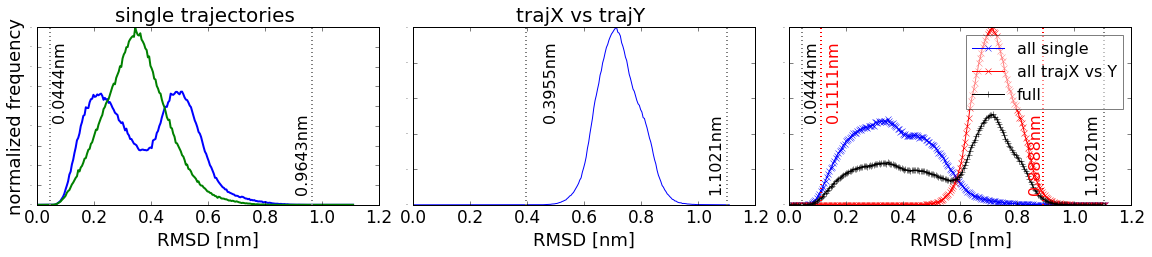

In [25]:
determineR_using_RMSD_distributions(TrajNameList=['V3_Gromacs1_stripped', 'V3_Gromacs2_stripped'], 
                                    SaveName='V3_Gromacs', SaveNamePdf='V3_Gromacs_dist.png', 
                                    SaveDIR='RMSD_distributions2/', RMSD_dist_DIR='RMSD_distributions2/', 
                                    BinFiles_DIR='RMSD_matrices2/', BinFile_precision='float32', Bins=250, Percent=0.99)

There is a significant difference between the flexible V3-loop (35aa) and Met-Enkephalin (5aa) in the RMSD distributions of 100ns simulations. Especially, the pair RMSD distribution between the two trajectories are much larger, indicating, that they both sample completely different conformational spaces. 

It is therefore not possible to extract a resolution/threshold $r$ which treat single and pair trajectories in the same fashion. A threshold $r \approx 0.4$nm reflects an average RMSD value for single trajectories, but will automatically result in a very low overlap, since the structures of different trajectories are at least $>0.4$nm away.

##### 3. Generate EventCurves

Here, we will produce event curves again for 100ns, 60ns and 30ns, to analyze the influence of the simulation time. Because Gromacs also uses the first frame by default, the corresponding ending frames must be set to __1001, 601 and 301__, respectively. The same can be applied on the __MaxNumberLines__ value. Then the values can be submitted in a for-loop.

As thresholds, it is recommended to screen through the entire range of RMSD distributions to analyze the overlap as a function of the threshold. Thus we use __ThresholdList=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]__ in [nm]

In [26]:
for StartFrame, EndingFrame in [(0,1001), (0,601), (0,301)]:
    Generate_EventCurves(TrajNameList=['V3_Gromacs1_stripped', 'V3_Gromacs2_stripped'], 
                         TrajLengthList=[1001, 1001], 
                         MatrixDir='RMSD_matrices2/', SaveDir='EventCurves2/', SaveName='V3_Gromacs', 
                         ThresholdList=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85], MaxNumberLines=1001, 
                         StartFrame=StartFrame, EndingFrame=EndingFrame, BinFile_precision='float32')

In [27]:
EventCurve2 = numpy.load('EventCurves2/V3_Gromacs_0-1001_noWeight.npy')

print EventCurve2.shape
print EventCurve2

(2002, 18)
[[   0    1    2 ...,  835 1001  987]
 [   1    1    2 ...,  803 1001  985]
 [   2    1    1 ...,  603 1000  855]
 ..., 
 [ 998    2    0 ..., 1001 1001 1001]
 [ 999    2    0 ...,  999  972 1001]
 [1000    2    0 ...,  991  850 1001]]


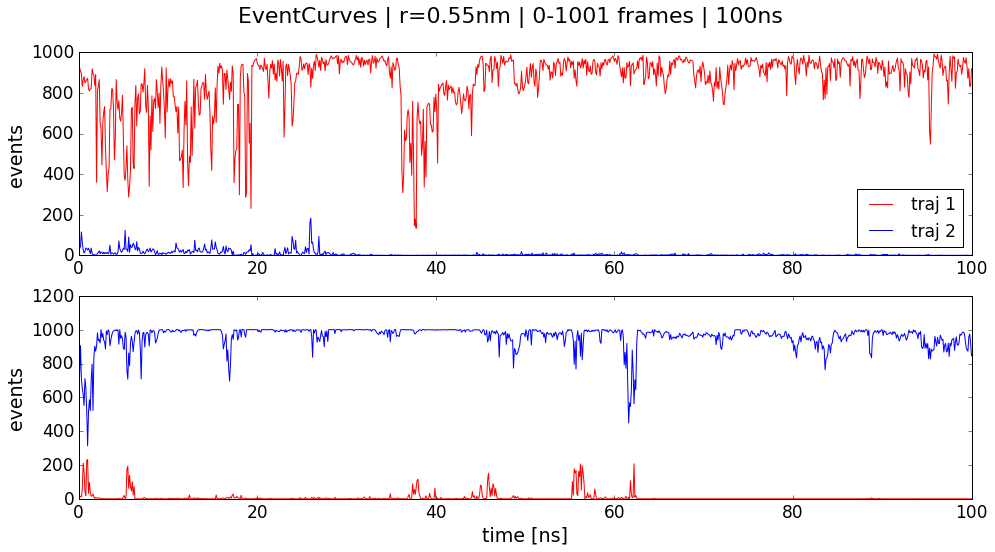

In [28]:
fig = plt.figure(figsize=(16,8));
plt.suptitle('EventCurves | r=0.55nm | 0-1001 frames | 100ns', fontsize=22);
plt.subplot2grid( (2,1), (0,0) );
plt.plot(EventCurve2[0:1001,0]/10., EventCurve2[0:1001,10], 'r-'); plt.yticks(fontsize=17); plt.xticks(fontsize=17);
plt.plot(EventCurve2[0:1001,0]/10., EventCurve2[0:1001,11], 'b-'); plt.ylabel('events', fontsize=19);
plt.legend(['traj 1', 'traj 2'], fontsize=17, loc=0)
plt.subplot2grid( (2,1), (1,0) );
plt.plot(EventCurve2[1001:2002,0]/10., EventCurve2[1001:2002,10], 'r-'); plt.yticks(fontsize=17);
plt.plot(EventCurve2[1001:2002,0]/10., EventCurve2[1001:2002,11], 'b-'); plt.ylabel('events', fontsize=19);
plt.xticks(fontsize=17); plt.xlabel('time [ns]', fontsize=19);

Here, one must use a relatively large threshold $r=0.55$nm, that both trajectories have any event occurences. This confirms the outcome from the RMSD distributions discussed above, that the trajectory itself which is also used as reference have almost always all structures in the r-neighborhood $r<0.55$nm. Thus the resolution is too coarse to see the influence of the underlying potential. On the other side, the other trajectory has almost no event, which could be expected by the pair RMSD distribution. Thus the overlap will be (almost) zero.

##### 4. Calculate and plot overlap (conformational | density)

The overlap is easily calculated by submitting the eventcurves by __EventNames__ parameters. Again, the same __CompareList=[([1],[2])]__ is used to calculate only the overlap between both involved trajectories.

Additionally, here we apply __AllPrject=False__, i.e. the overlap is calculated for every reference group separately. Here, the reference groups are the two different trajectories. The full overlap using both references is simply the average of both overlap values for the single trajectories.

In [31]:
for EventNames in ['V3_Gromacs_0-1001_noWeight.npy', 'V3_Gromacs_0-601_noWeight.npy', 'V3_Gromacs_0-301_noWeight.npy']:
    Calc_Overlap(EventDir='EventCurves2/', EventNames=EventNames, SaveDir='Overlap2/', SaveName='Overlap_V3_Gromacs', 
                 CompareList=[([1],[2])], AllPrject=False)

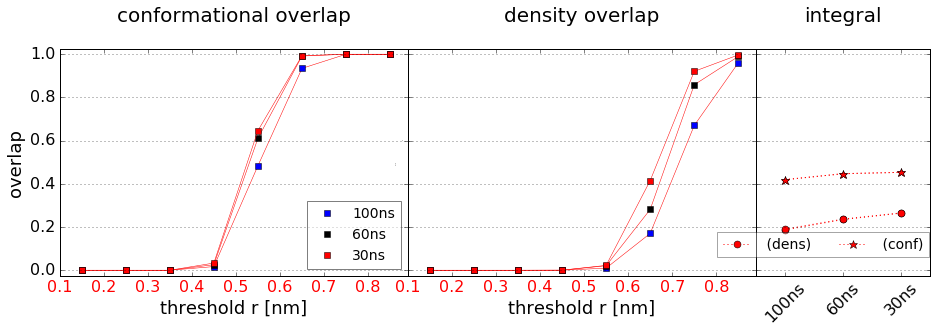

In [32]:
Plot_Overlap_VS_Threshold(OverlapDir='Overlap2/', 
                          OverlapList1=['Overlap_V3_Gromacs_0-1001_noWeight.txt',
                                        'Overlap_V3_Gromacs_0-601_noWeight.txt', 
                                        'Overlap_V3_Gromacs_0-301_noWeight.txt'], 
                          XLIM1=[0.1, 0.89], LegendList=['100ns', '60ns', '30ns'])

The overlap as a function of the threshold expresses the problem discussed above. The overlap has only a non-zero value, if the threshold is set to a large value, where the most structures are trivially in the r-neighborhood. Additionally, the insufficient sampling is shown, that for longer simulation times, the overlap is not better, which is of course also shown in the overlap as a function of the simulation time.

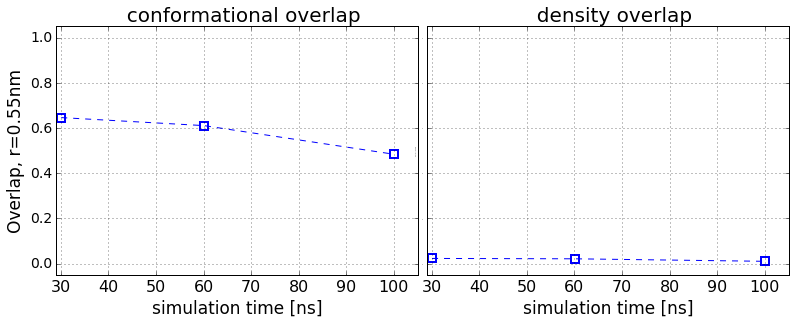

In [33]:
Plot_Overlap_VS_Time(OverlapDir='Overlap2/', OverlapList=['Overlap_V3_Gromacs_Start-End_noWeight.txt'], Threshold=0.55, 
                     SimTimeList=[(0,301), (0,601), (0,1001)], TimeStep=0.1)

Because the overlap was generated for every group respectively reference trajectory separately, we can process this information into the heatmaps by setting also __AllPrject=False__. Then the heatmap will be generated asymmetric, whereas the lower triangular is the projection on the first reference trajectory, and the upper triangular is the projection on the second.

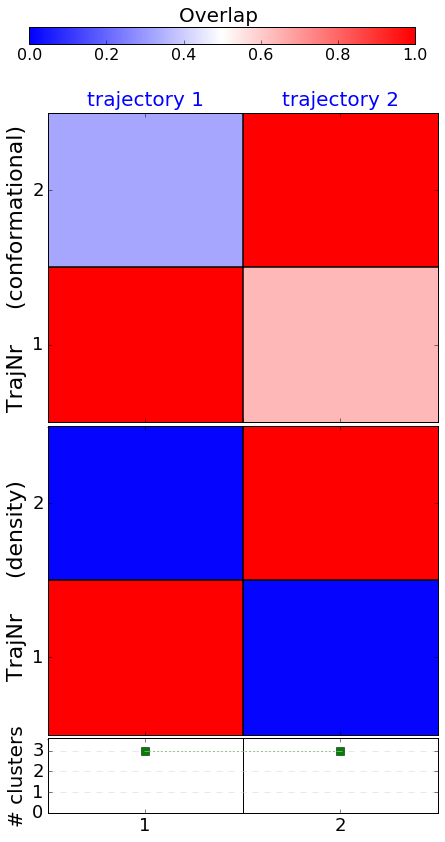

In [34]:
Plot_HeatMap_1vs1(OverlapDir='Overlap2/', FileName='Overlap_V3_Gromacs_0-1001_noWeight.txt', Threshold=0.55, 
                  ClusterDir='Clustering2/', ClusterFileName='V3_Gromacs_R0.2-0.55_0-1001_Centers_LOCAL.txt', 
                  AllPrject=False, Grid=[1], CaseTitles=['trajectory 1', 'trajectory 2'])

The overlap values are low as seen above, even for a threshold of $r=0.55$nm. That the threshold is quite large can also be seen that almost all structures are within one cluster, because there are only three clusters found for 1001 structures of a flexible molecule.

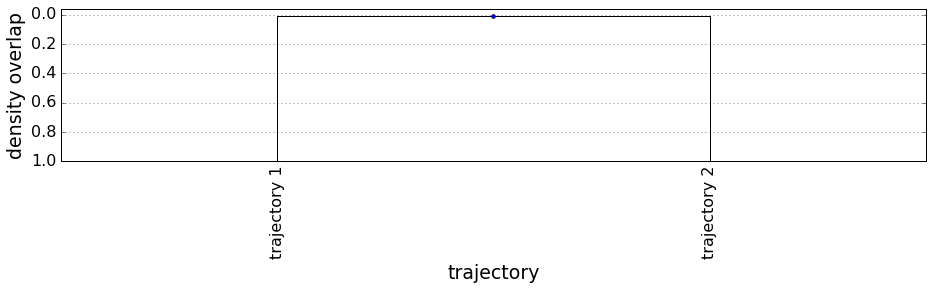

In [35]:
Plot_HeatMap_as_Dendro(OverlapDir='Overlap2/', FileName='Overlap_V3_Gromacs_0-1001_noWeight.txt', Threshold=0.55, 
                       Case='density', Labels=['trajectory 1', 'trajectory 2'])

## 3. Clustering

##### 1. Generate the clustering, merge different thresholds and plot the clustering profile

The clustering will this time be done locally for every trajectory separately (__GLOBAL=False__). Additionally, no reference structure is inserted thus the first frame of the corresponding trajectory is taken as the first centroid.

In [36]:
for Threshold in [0.2, 0.4, 0.55]:
    Generate_Clustering(MatrixDir='RMSD_matrices2/', SaveDir='Clustering2/', 
                        TrajNameList=['V3_Gromacs1_stripped', 'V3_Gromacs2_stripped'], 
                        TrajLengthList=[1001,1001], Threshold=Threshold, SaveName='V3_Gromacs', 
                        MaxNumberLines=1001, TimeStep=0.1, GLOBAL=False, BinFile_precision='float32')

In [37]:
Merge_Clustering_different_Thresholds(SingleClustDir='Clustering2/', SaveDir='Clustering2/',
                                      SaveName='V3_Gromacs', ThresholdList=[0.2, 0.4, 0.55], 
                                      StartFrame=0, EndingFrame=1001, GLOBAL=False)

In the clustering profile, one can see, that indeed the clustering starts with the first structure for both trajectories. 

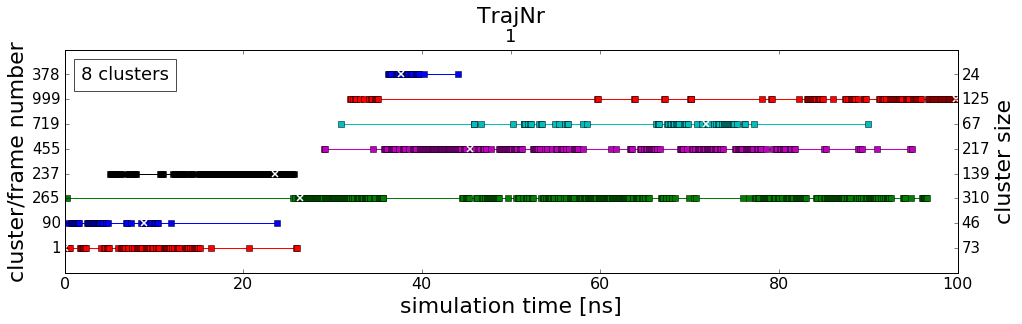

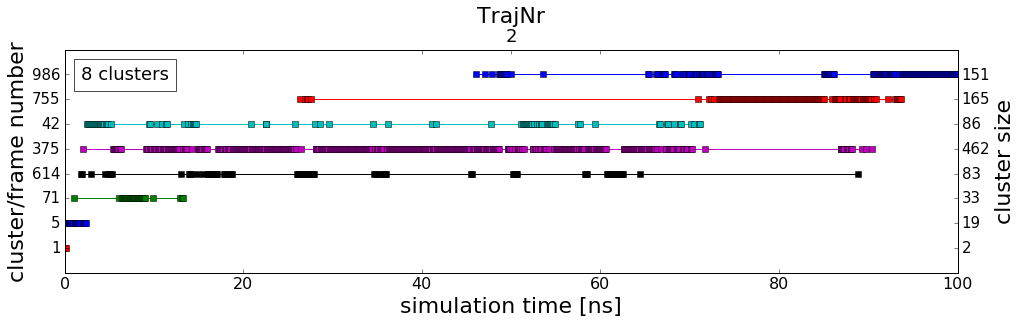

In [41]:
Plot_ClusterProfile(ClusterDir='Clustering2/', ClusterName='V3_Gromacs_R0.2-0.55_0-1001_LOCAL.txt', Global=False,
                    TimeStep=0.1, Threshold=0.4, TrjLenList=[100,100], FigSize=[16,4])

But there is a clear difference between both trajectories, where the first trajectory is almost split around 27ns into two parts, the second trajectory immediatly leave the starting structure and predominantly stays a long time in one cluster.

##### 2. Calculate the cluster distribution entropy (CDE) and the number of clusters found as a function of the simulation time

The cluster distribution entropy can be directly calculated from the single trajectory clustering without extracting the clustering from a global partitioning as done above. The only change comparing to the Met-Enkephalin molecule is the case parameter, which is set to __Case='LOCAL'__, because local clustering was done.

In [42]:
Generate_CDE_to_File(ClusterDIR='Clustering2/', ClusterFileName='V3_Gromacs_R0.2-0.55_0-1001_LOCAL.txt', 
                     ThresholdList=[0.2, 0.4, 0.55], Case='LOCAL', SaveDIR='Clustering2/', 
                     SaveName='CDE_V3_Gromacs_R0.2-0.55')

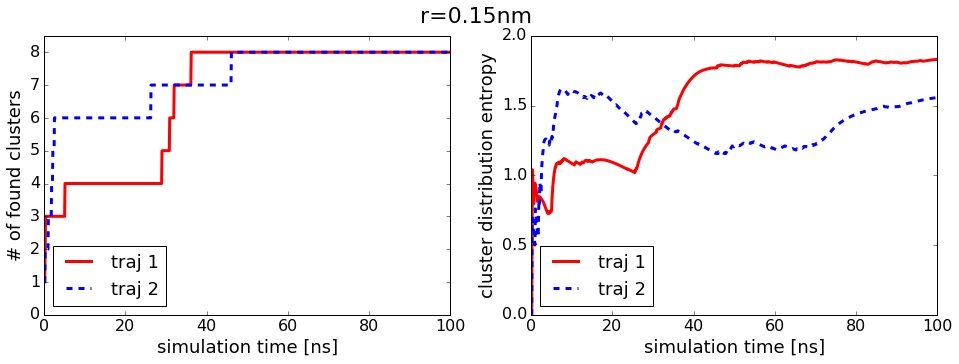

In [43]:
CDE2 = numpy.genfromtxt('Clustering2/CDE_V3_Gromacs_R0.2-0.55_LOCAL.txt')

fig = plt.figure(figsize=(16,5))
#-----
plt.subplot2grid( (1,2), (0,0) ); plt.suptitle('r=0.15nm', fontsize=22)
plt.plot(CDE2[0:1001,0]/10., CDE2[0:1001,6], 'r-', lw=3); plt.plot(CDE2[0:1001, 0]/10., CDE2[1001:2002,6], 'b--', lw=3);
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('# of found clusters', fontsize=18); plt.ylim([0,8.5])
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);
#-----
plt.subplot2grid( (1,2), (0,1) )
plt.plot(CDE2[0:1001,0]/10., CDE2[0:1001,8], 'r-', lw=3); plt.plot(CDE2[0:1001, 0]/10., CDE2[1001:2002,8], 'b--', lw=3); 
plt.xlabel('simulation time [ns]', fontsize=18); plt.ylabel('cluster distribution entropy', fontsize=18); 
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(['traj 1', 'traj 2'], fontsize=18, loc=0);

The number of found cluster indicates wrongly, that the sampling could be converged and all clusters are already found, which could be seen in the overlap analysis. Only the entropy for the second trajectory indicates, that the sampling is insufficient. Therefore, it is necessary not only to rely on single trajectory approaches.

##### 3. Investigate and plot the slopes

The corresponding slopes can be extracted by the following function:

In [44]:
Generate_Slope_Error(EntropyDIR='Clustering2/', EntropyName='CDE_V3_Gromacs_R0.2-0.55_LOCAL.txt', 
                     SaveDIR='Clustering2/', SaveName='Slope_V3_Gromacs_R0.2-0.55')

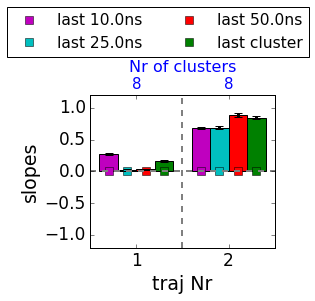

In [45]:
Plot_Slope_Error_Plateau_NrClust(SlopeDIR='Clustering2/', SlopeName='Slope_V3_Gromacs_R0.2-0.55_LOCAL.txt', 
                                 Threshold=0.4, Case='Entropy', TimeStep=0.1)

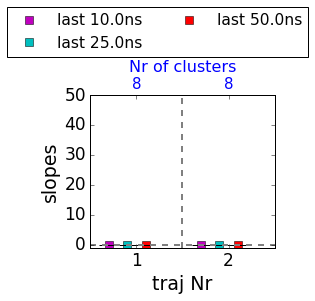

In [46]:
Plot_Slope_Error_Plateau_NrClust(SlopeDIR='Clustering2/', SlopeName='Slope_V3_Gromacs_R0.2-0.55_LOCAL.txt', 
                                 Threshold=0.4, Case='Cluster', TimeStep=0.1)

They give a condensed information about the behavior which was already discussed.

----

# VI. Summary & Outlook

The analysis aims to investigate Molecular Dynamics (MD) simulation sampling using multiple trajectories. This allows to access the sampling quality with multiple criterions

1. clustering
    - number of clusters
    - cluster distribution entropy
1. overlap
    - conformational overlap
    - density overlap
    
and decide, if the simulation converged and the sampling is sufficient (self-consistency). The analysis is based on a distance like matrix, whereas RMSD values are used. 

It is recommended to use multiple trajectories with multiple different conditions, for instance different starting conformations, different velocity seeds and similar. The more trajectories are used, the less probable is to sample only a small amount of the conformational space and run into the unknown unknowns problem not reaching slowly relaxing degrees of freedom.

Theoretically, it is possible to use the analysis also on a totally different problem.

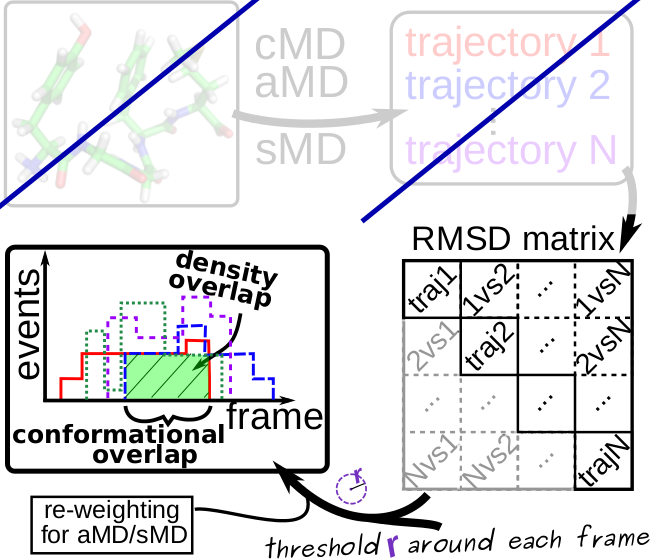

In [48]:
Image('OverlapCalculation_starting_with_RMSD.png', width=500)

The necessary observables of another scientific question need to be transformed into distance based block matrices. Then the analysis could start with an own distance-based measure calculating the self-consistency and overlap between multiple different systems.